# Progetto AI
## Diego Barbieri 000108033

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model
from dataclasses import dataclass
from typing import Tuple, List
import yaml
import argparse

import os
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Mounted at /content/drive


sets

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


## generatori

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data

traingen = datagenerator(mnist_x_train,fashion_mnist_x_train,32)
valgen = datagenerator(mnist_x_test,fashion_mnist_x_test,32)
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1024)

#Cosa consegnare

Come di consueto, dovrete consegnare un unico notebook eseguibile su Colab. Il notebook dovrà essere adeguatamente commentato, contenere l'intero tracciato dell'addestramento, il calcolo dell'MSE nel formato specificato sopra e alcuni esempi.

Buon lavoro!

# RELAZIONE

Vorrei dedicare un paio di parole al processo di sviluppo della soluzione finale riportata.

Indice:

- utilizzo delle competenze acquisite durante il corso
- utilizzo LLM
- ricerca su GitHub

Per arrivare alla realizzazione del modello finale [unet 5](#unet5) sono partito identificando e studiando i requisiti della consegna. L'obiettivo di separare due immagini mi ha subito fatto pensare alla realizzazione di un modello simil-unet, eppure in un primo momento ho tentato un approccio GAN, con pochi risultati. Durante la ricerca di nuove idee, mi sono lanciato nella realizzazione di un modello di test che accettasse iperparametri in modo da rendere più astratta la ricerca del modello desiderato. La soluzione migliore si è rivelata un modello generativo con un encoder e due decorder (per ogni training set).

Durante i vari addestramenti ho provato diverse combinazioni di parametri, sia intrinsechi al modello, sia riguardanti la fase di allenamento. La modularizzazione del codice (del notebook) mi ha permesso di focalizzarmi sulla creazione di una buona architettura, piuttosto che risolvere bug e/o cercare porzioni di codice sparse per il file.

L'utilizzo di LLM, tra cui ClaudeAI e ChatGPT, mi ha permesso di velocizzare esponenzialmente la ricerca di nuovi modelli e la creazione di tali, fornendomi la sintassi (non sempre corretta) della libreria TensorFlow e Keras.

La svolta (in termini di prestazioni) nel progetto l'ho raggiunta trovando progetti simili ed open source su GitHub.

Di seguito sono riportate le diverse versioni del modello. Solo delle più rilevanti sono riportati gli addestramenti.

# Testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def eval_model(real, predicted):
    """
    Calculate MSE between real and predicted image pairs.

    Args:
        real: Array-like of real images
        predicted: Array-like of predicted images

    Returns:
        float: Average MSE between the images

    Raises:
        ValueError: If inputs have different shapes or invalid dimensions
    """
    # Convert inputs to numpy arrays if they aren't already
    real_image = np.asarray(real).squeeze()
    predicted_image = np.asarray(predicted).squeeze()

    # Validate shapes
    if real_image.shape != predicted_image.shape:
        raise ValueError(f"Shape mismatch: real {real_image.shape} != predicted {predicted_image.shape}")

    # Check for NaN or Inf values
    if np.any(np.isnan(real_image)) or np.any(np.isnan(predicted_image)):
        print("Warning: NaN values detected in the images")
        return np.nan
    if np.any(np.isinf(real_image)) or np.any(np.isinf(predicted_image)):
        print("Warning: Infinite values detected in the images")
        return np.nan

    # Compute MSE
    mse_value = np.mean((predicted_image - real_image) ** 2)
    return mse_value

def test_model(model, test_generator, num_samples=10, plot_example=True, channel_idx=0):
    """
    Evaluate a model's performance using MSE and optionally plot example predictions.

    Args:
        model: Model with predict method
        test_generator: Generator yielding (x_mixed, x_concat) tuples
        num_samples: Number of samples to evaluate
        plot_example: Whether to plot an example prediction
        channel_idx: Index of the channel to plot for multi-channel images

    Returns:
        tuple: (mean_mse, std_mse) or (None, None) if no valid samples
    """
    errors = []

    # Evaluate samples with progress bar
    for _ in tqdm(range(num_samples), desc="Evaluating model"):
        try:
            x_mixed, x_concat = next(test_generator)
            reconstructed = model.predict(x_mixed)

            mse_value = eval_model(x_concat, reconstructed)
            if not np.isnan(mse_value):
                errors.append(mse_value)

        except Exception as e:
            print(f"Error processing sample: {str(e)}")
            continue

    # Compute and return statistics
    if errors:
        mse = np.mean(errors)
        std = np.std(errors)

        print(f"MSE = {mse:.6f}")
        print(f"Standard deviation = {std:.6f}")
        return mse, std
    else:
        print("No valid samples for evaluation.")
        return None, None

# GAN - not working


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class UNetGenerator(nn.Module):
    def __init__(self, pretrained_model):
        super(UNetGenerator, self).__init__()

        self.pretrained = pretrained_model  # Load the pre-trained model
        self.pretrained.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapt input to grayscale

        # Feature extraction layers
        self.encoder = self.pretrained.backbone  # Use only the feature extractor

        # Two separate output layers for img1 and img2
        self.out1 = nn.Conv2d(2048, 1, kernel_size=1)  # Output for img1
        self.out2 = nn.Conv2d(2048, 1, kernel_size=1)  # Output for img2

    def forward(self, x):
        features = self.encoder(x)  # Extract features from pre-trained model
        img1 = self.out1(features)  # First image output
        img2 = self.out2(features)  # Second image output
        return torch.sigmoid(img1), torch.sigmoid(img2)  # Normalize output


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 16x16
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 8x8
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(8*8*128, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)  # Concatenazione lungo il canale
        return self.model(x)


as Loss function i want to use binary cross entropy.

> Add blockquote



# 1 ENCODER DUE DECONDER


## minimale

In [ ]:
def create_minimal_model(input_shape=(32, 32, 1)):
    input_layer = layers.Input(shape=input_shape)

    # Minimal encoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    encoder_output = x

    # Two minimal decoders
    def decoder_block(input_tensor):
        x = layers.Conv2DTranspose(16, (3, 3), strides=2, padding="same", activation="relu")(input_tensor)
        x = layers.Conv2DTranspose(8, (3, 3), strides=2, padding="same", activation="relu")(x)
        return x

    # First decoder
    decoder_1 = decoder_block(encoder_output)
    output_1 = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(decoder_1)

    # Second decoder
    decoder_2 = decoder_block(encoder_output)
    output_2 = layers.Conv2D(1, (3, 3), activation="relu", padding="same")(decoder_2)

    # Concatenate outputs along axis=2 to match the original model
    output_final = Concatenate(axis=2, dtype="float32")([output_1, output_2])

    return Model(inputs=input_layer, outputs=output_final, name="minimal")

In [ ]:
minimal = create_minimal_model(input_shape=(32, 32, 1))

minimal.summary()

MINIMAL_WEIGHTS_PATH = '/content/drive/MyDrive/unet/minimal.weights.h5'

Model: "minimal"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 32)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 16)     │          4,624 │ max_pooling2d_1[0][0]  │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 16, 16, 16)     │          4,624 │ max_pooling2d_1[0][0]  │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 8)      │          1,160 │ conv2d_transpose[0][0] │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 32, 32, 8)      │          1,160 │ conv2d_transpose_2[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 1)      │             73 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 1)      │             73 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 64, 1)      │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,514 (64.51 KB)

 Trainable params: 16,514 (64.51 KB)

 Non-trainable params: 0 (0.00 B)

## unet1

In [ ]:
def create_model_unet1(input_shape=(32, 32, 1)):
    input_layer = layers.Input(shape=input_shape)

    # Encoder with skip connections
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    skip1 = x1
    x1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    skip2 = x2
    x2 = layers.MaxPooling2D((2, 2))(x2)

    encoder_output = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    encoder_output = layers.Dropout(0.5)(encoder_output)

    def decoder_block(x, skip2, skip1):
        x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip2])
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

        x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip1])
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        return x

    # Two decoders with skip connections
    mnist_decoder = decoder_block(encoder_output, skip2, skip1)
    mnist_output = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(mnist_decoder)

    fashion_decoder = decoder_block(encoder_output, skip2, skip1)
    fashion_output = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(fashion_decoder)
    fashion_output = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(fashion_output)

    return Model(inputs=input_layer, outputs=[mnist_output, fashion_output])

## unet 2

In [ ]:
def create_model_unet2(input_shape=(32, 32, 1)):
    input_layer = layers.Input(shape=input_shape)

    x1 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x1)
    skip1 = x1
    x1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    skip2 = x2
    x2 = layers.MaxPooling2D((2, 2))(x2)

    encoder_output = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x2)
    encoder_output = layers.Dropout(0.5)(encoder_output)

    def decoder_block(x, skip2, skip1):
        x = layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip2])
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        residual = x
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.Add()([x, residual])

        x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip1])
        x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        return x

    mnist_decoder = decoder_block(encoder_output, skip2, skip1)
    mnist_output = layers.Conv2D(1, (5, 5), activation='tanh', padding='same')(mnist_decoder)

    fashion_decoder = decoder_block(encoder_output, skip2, skip1)
    fashion_output = layers.Conv2D(1, (5, 5), activation='tanh', padding='same')(fashion_decoder)

    return Model(inputs=input_layer, outputs=[mnist_output, fashion_output])

## unet 3

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class DoubleConv(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.SeparableConv2D(filters, kernel_size, padding='same')
        self.norm1 = layers.LayerNormalization()
        self.conv2 = layers.SeparableConv2D(filters, kernel_size, padding='same')
        self.norm2 = layers.LayerNormalization()
        self.act = layers.ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.norm2(x)
        return self.act(x)

class EncoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.double_conv = DoubleConv(filters, kernel_size)
        self.pool = layers.AveragePooling2D((2, 2))

    def call(self, inputs):
        skip = self.double_conv(inputs)
        output = self.pool(skip)
        return output, skip

class DecoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.up_conv = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')
        self.double_conv = DoubleConv(filters, kernel_size)

    def call(self, inputs, skip):
        x = self.up_conv(inputs)
        x = layers.Concatenate()([x, skip])
        return self.double_conv(x)

def create_improved_unet(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    enc1 = EncoderBlock(32, (3, 3))
    enc2 = EncoderBlock(64, (3, 3))
    enc3 = EncoderBlock(128, (3, 3))

    x, skip1 = enc1(inputs)
    x, skip2 = enc2(x)
    x, skip3 = enc3(x)

    # Bottleneck
    bridge = DoubleConv(256, (3, 3))
    x = bridge(x)
    x = layers.Dropout(0.2)(x)

    # Decoder for MNIST
    mnist_dec = DecoderBlock(128, (3, 3))(x, skip3)
    mnist_dec = DecoderBlock(64, (3, 3))(mnist_dec, skip2)
    mnist_dec = DecoderBlock(32, (3, 3))(mnist_dec, skip1)
    mnist_output = layers.Conv2D(1, (1, 1), activation='tanh', name='mnist_output')(mnist_dec)

    # Decoder for Fashion-MNIST
    fashion_dec = DecoderBlock(128, (3, 3))(x, skip3)
    fashion_dec = DecoderBlock(64, (3, 3))(fashion_dec, skip2)
    fashion_dec = DecoderBlock(32, (3, 3))(fashion_dec, skip1)
    fashion_output = layers.Conv2D(1, (1, 1), activation='tanh', name='fashion_output')(fashion_dec)

    return Model(inputs=inputs, outputs=[mnist_output, fashion_output], name="unet3")

In [ ]:
unet3 = create_improved_unet(input_shape=(32, 32, 1))

unet3.summary()

UNET3_WEIGHTS_PATH = '/content/drive/MyDrive/unet/unet3.weights.h5'

Model: "unet3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_6           │ [(None, 16, 16, 32),   │          1,545 │ input_layer_3[0][0]    │
│ (EncoderBlock)            │ (None, 32, 32, 32)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_7           │ [(None, 8, 8, 64),     │          7,392 │ encoder_block_6[0][0]  │
│ (EncoderBlock)            │ (None, 16, 16, 64)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_8           │ [(None, 4, 4, 128),    │         27,072 │ encoder_block_7[0][0]  │
│ (EncoderBlock)            │ (None, 8, 8, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ double_conv_23            │ (None, 4, 4, 256)      │        103,296 │ encoder_block_8[0][0]  │
│ (DoubleConv)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 4, 4, 256)      │              0 │ double_conv_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_12          │ (None, 8, 8, 128)      │        184,576 │ dropout_3[0][0],       │
│ (DecoderBlock)            │                        │                │ encoder_block_8[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_15          │ (None, 8, 8, 128)      │        184,576 │ dropout_3[0][0],       │
│ (DecoderBlock)            │                        │                │ encoder_block_8[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_13          │ (None, 16, 16, 64)     │         47,232 │ decoder_block_12[0][0… │
│ (DecoderBlock)            │                        │                │ encoder_block_7[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_16          │ (None, 16, 16, 64)     │         47,232 │ decoder_block_15[0][0… │
│ (DecoderBlock)            │                        │                │ encoder_block_7[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_14          │ (None, 32, 32, 32)     │         12,352 │ decoder_block_13[0][0… │
│ (DecoderBlock)            │                        │                │ encoder_block_6[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_17          │ (None, 32, 32, 32)     │         12,352 │ decoder_block_16[0][0… │
│ (DecoderBlock)            │                        │                │ encoder_block_6[0][1]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mnist_output (Conv2D)     │ (None, 32, 32, 1)      │             33 │ decoder_block_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fashion_output (Conv2D)   │ (None, 32, 32, 1)      │             33 │ decoder_block_17[0][0] │
└──────────────────────

 Total params: 627,691 (2.39 MB)

 Trainable params: 627,691 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

no weights found


## unet 4

In [ ]:
class DoubleConv(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.SeparableConv2D(filters, kernel_size, padding='same')
        self.norm1 = layers.BatchNormalization()
        self.conv2 = layers.SeparableConv2D(filters, kernel_size, padding='same')
        self.norm2 = layers.BatchNormalization()
        self.act = layers.LeakyReLU(alpha=0.2)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.norm1(x, training=training)
        x = self.act(x)
        x = self.conv2(x)
        x = self.norm2(x, training=training)
        return self.act(x)

class EncoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.double_conv = DoubleConv(filters, kernel_size)
        self.pool = layers.MaxPooling2D((2, 2))

    def call(self, inputs, training=None):
        skip = self.double_conv(inputs, training=training)
        output = self.pool(skip)
        return output, skip

class DecoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.up_conv = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')
        self.double_conv = DoubleConv(filters, kernel_size)

    def call(self, inputs, skip, training=None):
        x = self.up_conv(inputs)
        x = layers.Concatenate()([x, skip])
        return self.double_conv(x, training=training)

def create_unet_4(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    # Initial feature extraction
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Encoder
    enc1 = EncoderBlock(64, (3, 3))
    enc2 = EncoderBlock(128, (3, 3))
    enc3 = EncoderBlock(256, (3, 3))

    x, skip1 = enc1(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x, skip2 = enc2(x)
    x = layers.SpatialDropout2D(0.1)(x)
    x, skip3 = enc3(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Bottleneck
    x = DoubleConv(512, (3, 3))(x)
    x = layers.SpatialDropout2D(0.35)(x)

    # Decoder for MNIST
    mnist_dec = DecoderBlock(256, (3, 3))(x, skip3)
    mnist_dec = layers.SpatialDropout2D(0.1)(mnist_dec)
    mnist_dec = DecoderBlock(128, (3, 3))(mnist_dec, skip2)
    mnist_dec = layers.SpatialDropout2D(0.1)(mnist_dec)
    mnist_dec = DecoderBlock(64, (3, 3))(mnist_dec, skip1)

    # Final MNIST output with tanh to match [-1,1] range
    mnist_output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same', name='mnist_output')(mnist_dec)

    # Decoder for Fashion-MNIST
    fashion_dec = DecoderBlock(256, (3, 3))(x, skip3)
    fashion_dec = layers.SpatialDropout2D(0.1)(fashion_dec)
    fashion_dec = DecoderBlock(128, (3, 3))(fashion_dec, skip2)
    fashion_dec = layers.SpatialDropout2D(0.1)(fashion_dec)
    fashion_dec = DecoderBlock(64, (3, 3))(fashion_dec, skip1)

    # Final Fashion-MNIST output with tanh to match [-1,1] range
    fashion_output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same', name='fashion_dec_output')(fashion_dec)

    model = Model(inputs=inputs, outputs=[mnist_output, fashion_output], name="unet3")

    return model

In [ ]:
unet4 = create_unet_4(input_shape=(32, 32, 1))

unet4.summary()

UNET4_WEIGHTS_PATH = '/content/drive/MyDrive/unet/unet4.weights.h5'

try:
  unet4.load_weights(UNET4_WEIGHTS_PATH)
except:
  print("no weights found")
  pass

models.append(unet4)

Model: "unet3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 64)     │            640 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_123   │ (None, 32, 32, 64)     │            256 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_55            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_30          │ [(None, 16, 16, 64),   │          9,984 │ leaky_re_lu_55[0][0]   │
│ (EncoderBlock)            │ (None, 32, 32, 64)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_30      │ (None, 16, 16, 64)     │              0 │ encoder_block_30[0][0] │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_31          │ [(None, 8, 8, 128),    │         27,584 │ spatial_dropout2d_30[… │
│ (EncoderBlock)            │ (None, 16, 16, 128)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_31      │ (None, 8, 8, 128)      │              0 │ encoder_block_31[0][0] │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_32          │ [(None, 4, 4, 256),    │        104,320 │ spatial_dropout2d_31[… │
│ (EncoderBlock)            │ (None, 8, 8, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_32      │ (None, 4, 4, 256)      │              0 │ encoder_block_32[0][0] │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ double_conv_85            │ (None, 4, 4, 512)      │        405,248 │ spatial_dropout2d_32[… │
│ (DoubleConv)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_33      │ (None, 4, 4, 512)      │              0 │ double_conv_85[0][0]   │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_42          │ (None, 8, 8, 256)      │        730,624 │ spatial_dropout2d_33[… │
│ (DecoderBlock)            │                        │                │ encoder_block_32[0][1] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_45     

 Total params: 2,474,562 (9.44 MB)

 Trainable params: 2,467,010 (9.41 MB)

 Non-trainable params: 7,552 (29.50 KB)

no weights found


## unet 5

In [ ]:
def blocco_codificatore(features_input, indice_livello, num_livelli, num_filtri, conv_per_blocco, livelli_skip, decodifica=False):
    """
    Implementa un blocco del codificatore della rete U-Net.

    Parametri:
        features_input: Tensore di input. Nel primo livello è l'immagine, nei successivi è l'output del livello precedente.
        indice_livello: (int) Indice del blocco corrente nella struttura. Es: il primo blocco ha indice 0.
        num_livelli: (int) Numero totale di livelli nella parte di codifica. Include anche il ponte centrale.
        num_filtri: (int) Numero di filtri da utilizzare nei layer Conv2D.
        conv_per_blocco: (int) Numero di layer Conv2D utilizzati in ogni blocco.
        livelli_skip: Lista dei layer del codificatore da utilizzare per le connessioni skip.
        decodifica: (bool) Se True, disabilita il MaxPooling e altre operazioni non necessarie nella fase di decodifica.

    Ritorna:
        Tuple (features_output, num_filtri_aggiornato)
    """
    features = features_input

    # Applica la sequenza di convoluzioni
    for _ in range(conv_per_blocco):
        features = Conv2D(num_filtri, 3, 1, padding='same')(features)
        features = BatchNormalization()(features)
        features = ReLU()(features)

    # Se non è un blocco di decodifica e non è l'ultimo livello
    if not(decodifica) and (indice_livello < num_livelli-1):
        livelli_skip.append(features)
        features = MaxPooling2D(padding='same')(features)
        num_filtri = num_filtri * 2

    return features, num_filtri


def blocco_decodificatore(features_input, indice_livello, num_livelli, num_filtri, conv_per_blocco, livelli_skip):
    """
    Implementa un blocco del decodificatore della rete U-Net.

    Parametri:
        features_input: Tensore di input dal livello precedente.
        indice_livello: (int) Indice del blocco corrente.
        num_livelli: (int) Numero totale di livelli.
        num_filtri: (int) Numero di filtri da utilizzare.
        conv_per_blocco: (int) Numero di layer Conv2D per blocco.
        livelli_skip: Lista dei layer per le connessioni skip.

    Ritorna:
        Tuple (features_output, num_filtri_aggiornato)
    """
    # Dimezza il numero di filtri
    num_filtri = num_filtri // 2

    # Deconvoluzione
    features = Conv2DTranspose(num_filtri, 3, 2, padding='same')(features_input)

    # Connessione skip
    features = concatenate([features, livelli_skip.pop(-1)])

    # Convoluzioni
    features, _ = blocco_codificatore(features, indice_livello, num_livelli,
                                    num_filtri, conv_per_blocco, livelli_skip, decodifica=True)

    return features, num_filtri


def create_unet_5(dimensione_input, num_filtri_iniziali=32, num_livelli=4, conv_per_blocco=2):
    """
    Crea un modello U-Net per la segmentazione di immagini.

    Parametri:
        dimensione_input: (tuple) Dimensioni del tensore di input (altezza, larghezza, canali).
        num_filtri_iniziali: (int) Numero iniziale di filtri per i layer Conv2D.
        num_livelli: (int) Numero di livelli nella rete. Include il ponte centrale.
        conv_per_blocco: (int) Numero di layer Conv2D per ogni blocco.

    Ritorna:
        Istanza di keras.models.Model
    """
    input_tensor = Input(shape=dimensione_input)
    livelli_skip = []
    features = input_tensor
    num_filtri = num_filtri_iniziali

    # Costruzione encoder
    for idx_livello in range(num_livelli):
        features, num_filtri = blocco_codificatore(features, idx_livello, num_livelli,
                                                 num_filtri, conv_per_blocco, livelli_skip)

    # Costruzione decoder
    for idx_livello in range(num_livelli-1):
        features, num_filtri = blocco_decodificatore(features, idx_livello, num_livelli,
                                                   num_filtri, conv_per_blocco, livelli_skip)

    # Layer di output
    output_1 = Conv2D(1, 1, activation='relu')(features)
    output_2 = Conv2D(1, 1, activation='relu')(features)
    output_finale = Concatenate(axis=2, dtype="float32")([output_1, output_2])

    return Model(input_tensor, output_finale, name="unet5")

In [ ]:
unet5 = create_unet_5(dimensione_input=(32, 32, 1), num_filtri_iniziali=128, num_livelli=3, conv_per_blocco=2)

unet5.summary()

UNET5_WEIGHTS_PATH = '/content/drive/MyDrive/unet/unet5best.weights.h5'

Model: "unet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │          1,280 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 256)    │          1,024 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 16, 16, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 16, 16, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├──────────────────────

 Total params: 8,272,130 (31.56 MB)

 Trainable params: 8,267,010 (31.54 MB)

 Non-trainable params: 5,120 (20.00 KB)

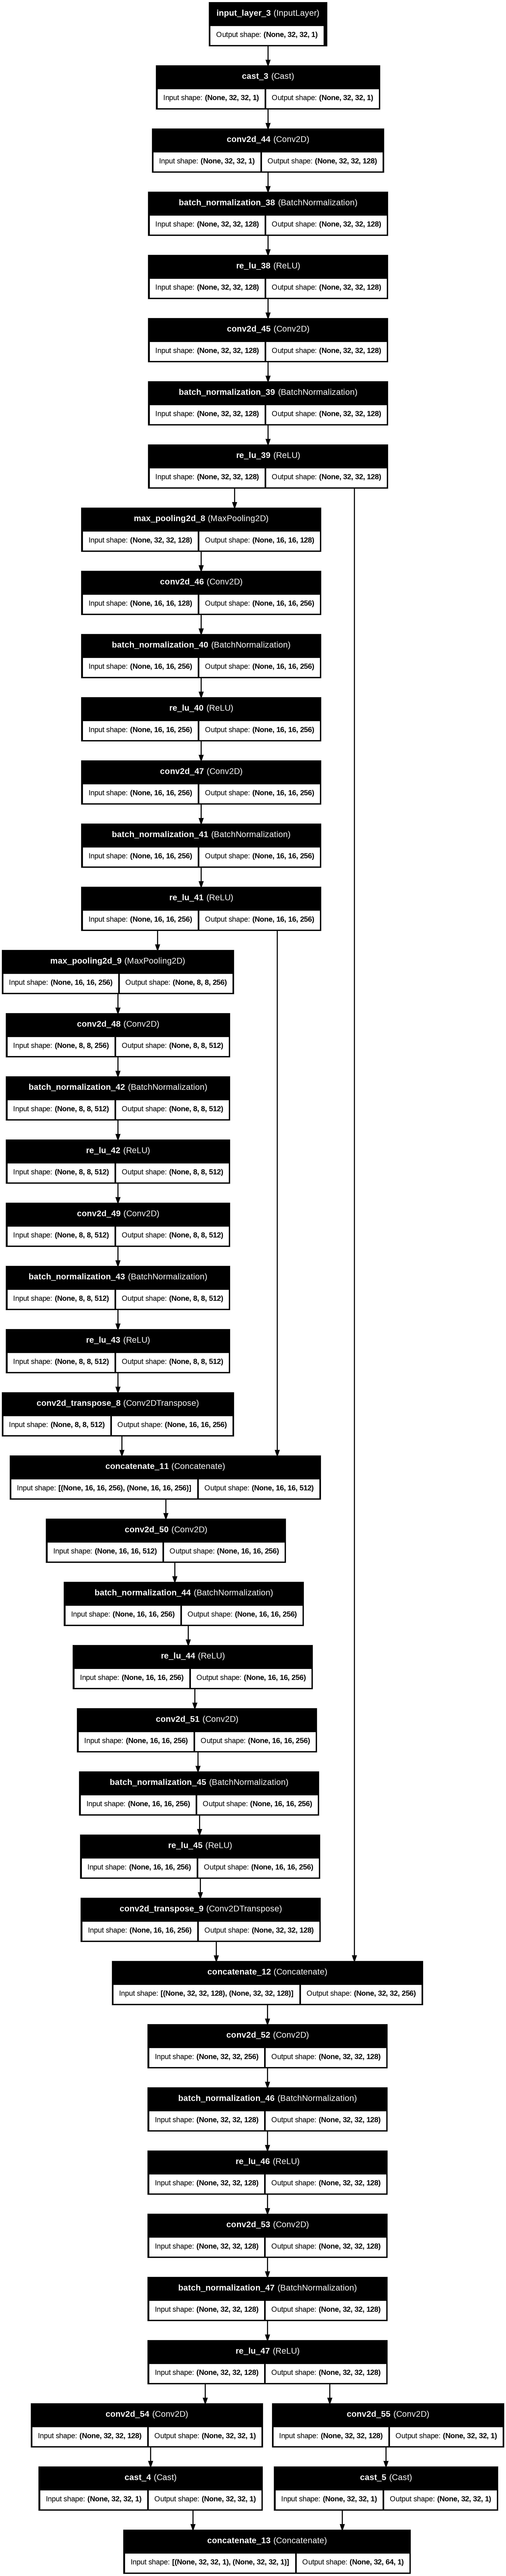

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model

plot_model(unet5, to_file='model.png', show_shapes=True, show_layer_names=True)

## iperparametri

In [ ]:
!pip install keras-tuner

import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
@dataclass
class ModelConfig:
    input_shape: Tuple[int, int, int] = (32, 32, 1)
    initial_filters_choices: List[int] = (16, 32, 64)
    encoder_layers_choices: List[int] = (2, 3, 4)
    filter_growth_rate_choices: List[int] = (1, 2)
    dropout_rate_choices: List[float] = (0.2, 0.3, 0.4)
    activation_choices: List[str] = ('relu', 'elu')
    final_activation: str = 'tanh'
    use_batch_norm: bool = True
    initial_lr_choices: List[float] = (1e-3, 1e-4)
    use_residual: bool = True

@dataclass
class TrainingConfig:
    batch_size_choices: List[int] = (32, 64, 128)
    epochs: int = 10
    initial_lr_choices: List[float] = (1e-3, 1e-4)
    early_stopping_patience: int = 10
    reduce_lr_patience: int = 5
    reduce_lr_factor: float = 0.5
    weights_path: str = 'best_hypermodel.weights.h5'
    max_trials: int = 10  # Number of different hyperparameter combinations to try

class HyperModel(kt.HyperModel):
    def __init__(self, model_config: ModelConfig):
        super().__init__()
        self.model_config = model_config

    def build(self, hp):
        # Hyperparameters to tune
        initial_filters = hp.Choice('initial_filters',
                                  values=self.model_config.initial_filters_choices)
        encoder_layers = hp.Choice('encoder_layers',
                                 values=self.model_config.encoder_layers_choices)
        filter_growth_rate = hp.Choice('filter_growth_rate',
                                     values=self.model_config.filter_growth_rate_choices)
        dropout_rate = hp.Choice('dropout_rate',
                               values=self.model_config.dropout_rate_choices)
        activation = hp.Choice('activation',
                             values=self.model_config.activation_choices)

        # Input layer
        input_layer = layers.Input(shape=self.model_config.input_shape)

        # Encoder
        x = input_layer
        skips = []
        filters = initial_filters
        kernel_sizes = [(5, 5), (3, 3), (2, 2)] * encoder_layers

        for i in range(encoder_layers):
            x = layers.Conv2D(filters, kernel_sizes[i], activation=activation, padding='same')(x)
            if self.model_config.use_batch_norm:
                x = layers.BatchNormalization()(x)
            x = layers.Conv2D(filters, kernel_sizes[i], activation=activation, padding='same')(x)
            skip = x
            x = layers.MaxPooling2D((2, 2))(x)
            skips.append(skip)
            filters *= filter_growth_rate

        # Bottleneck
        x = layers.Conv2D(filters, kernel_sizes[-1], activation=activation, padding='same')(x)
        x = layers.Dropout(dropout_rate)(x)

        # Decoder for MNIST
        x_mnist = x
        for i in range(encoder_layers):
            filters //= filter_growth_rate
            x_mnist = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x_mnist)
            x_mnist = layers.Concatenate()([x_mnist, skips[-(i+1)]])
            x_mnist = layers.Conv2D(filters, kernel_sizes[-(i+1)], activation=activation, padding='same')(x_mnist)
            if self.model_config.use_batch_norm:
                x_mnist = layers.BatchNormalization()(x_mnist)

            if self.model_config.use_residual:
                residual = x_mnist
                x_mnist = layers.Conv2D(filters, kernel_sizes[-(i+1)], activation=activation, padding='same')(x_mnist)
                x_mnist = layers.Add()([x_mnist, residual])

        mnist_output = layers.Conv2D(self.model_config.input_shape[-1], (1, 1),
                                   activation=self.model_config.final_activation,
                                   padding='same')(x_mnist)

        # Decoder for Fashion-MNIST
        x_fashion = x
        filters = x.shape[-1]
        for i in range(encoder_layers):
            filters //= filter_growth_rate
            x_fashion = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x_fashion)
            x_fashion = layers.Concatenate()([x_fashion, skips[-(i+1)]])
            x_fashion = layers.Conv2D(filters, kernel_sizes[-(i+1)], activation=activation, padding='same')(x_fashion)
            if self.model_config.use_batch_norm:
                x_fashion = layers.BatchNormalization()(x_fashion)

            if self.model_config.use_residual:
                residual = x_fashion
                x_fashion = layers.Conv2D(filters, kernel_sizes[-(i+1)], activation=activation, padding='same')(x_fashion)
                x_fashion = layers.Add()([x_fashion, residual])

        fashion_output = layers.Conv2D(self.model_config.input_shape[-1], (1, 1),
                                     activation=self.model_config.final_activation,
                                     padding='same')(x_fashion)

        model = Model(inputs=input_layer, outputs=[mnist_output, fashion_output], name="iperparametri")

        # Compile model
        lr = hp.Choice('learning_rate', values=self.model_config.initial_lr_choices)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                     loss=['mse', 'mse'])

        return model

# Define save function
def save_hyperparameters_to_drive(best_hps, training_config):
    # Generate a unique filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"/content/drive/MyDrive/hyperparameters/best_hps_{timestamp}.yaml"

    # Prepare hyperparameters dictionary
    hps_dict = {
        'initial_filters': best_hps.get('initial_filters'),
        'encoder_layers': best_hps.get('encoder_layers'),
        'filter_growth_rate': best_hps.get('filter_growth_rate'),
        'dropout_rate': best_hps.get('dropout_rate'),
        'activation': best_hps.get('activation'),
        'learning_rate': best_hps.get('learning_rate')
    }

    # Ensure directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Save the hyperparameters as YAML
    with open(filename, 'w') as f:
        yaml.dump(hps_dict, f)

    print(f"Hyperparameters saved to {filename}")

def train_with_tuner(model_config: ModelConfig, training_config: TrainingConfig,
                    train_data, val_data):
    tuner = kt.RandomSearch(
        HyperModel(model_config),
        objective='val_loss',
        max_trials=training_config.max_trials,
        directory='hyperparameter_tuning',
        project_name='dual_autoencoder'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=training_config.early_stopping_patience,
        restore_best_weights=True
    )

    tuner.search(
        train_data,
        validation_data=val_data,
        epochs=training_config.epochs,
        callbacks=[stop_early]
    )

    # Get best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print best hyperparameters
    print("\nBest Hyperparameters:")
    print(f"Initial filters: {best_hps.get('initial_filters')}")
    print(f"Encoder layers: {best_hps.get('encoder_layers')}")
    print(f"Filter growth rate: {best_hps.get('filter_growth_rate')}")
    print(f"Dropout rate: {best_hps.get('dropout_rate')}")
    print(f"Activation: {best_hps.get('activation')}")
    print(f"Learning rate: {best_hps.get('learning_rate')}")

    # Save hyperparameters to Google Drive
    save_hyperparameters_to_drive(best_hps, training_config)

    return best_model, best_hps

def load_config():
    # look for best config save


    # Train with hyperparameter tuning
    best_model, best_hps = train_with_tuner(model_config, training_config,
                                           traingen, onegen)

    # Save best model
    best_model.save_weights(training_config.weights_path)

    # Test best model
    test_model(best_model, onegen)

In [ ]:
def reconstruct_model_from_config(config, model_config=None):
    """
    Reconstruct the model using saved hyperparameters

    Args:
        config (dict): Hyperparameters dictionary
        model_config (ModelConfig, optional): Base model configuration

    Returns:
        tf.keras.Model: Reconstructed model
    """
    # Use default ModelConfig if not provided
    if model_config is None:
        model_config = ModelConfig()

    # Override model config with loaded parameters
    model_config.initial_filters_choices = [config['initial_filters']]
    model_config.encoder_layers_choices = [config['encoder_layers']]
    model_config.filter_growth_rate_choices = [config['filter_growth_rate']]
    model_config.dropout_rate_choices = [config['dropout_rate']]
    model_config.activation_choices = [config['activation']]

    # Create HyperModel with modified configuration
    hypermodel = HyperModel(model_config)

    # Create a dummy HyperParameters object
    hp = kt.HyperParameters()
    hp.values.update({
        'initial_filters': config['initial_filters'],
        'encoder_layers': config['encoder_layers'],
        'filter_growth_rate': config['filter_growth_rate'],
        'dropout_rate': config['dropout_rate'],
        'activation': config['activation'],
        'learning_rate': config['learning_rate']
    })

    # Build and return the model
    return hypermodel.build(hp)

# Example usage
def load_config_from_drive(filename):
    with open(filename, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load config
config_path = '/content/drive/MyDrive/hyperparameters/best_hps_20250207_152413.yaml'
config = load_config_from_drive(config_path)

# Reconstruct model
best_model = reconstruct_model_from_config(config)

# Load pre-trained weights
training_config = TrainingConfig()
best_model.load_weights(training_config.weights_path)

best_model.summary()

# for testing
models.append(best_model)

Model: "iperparametri"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_162 (Conv2D)       │ (None, 32, 32, 64)     │          1,664 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 32, 32, 64)     │            256 │ conv2d_162[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_163 (Conv2D)       │ (None, 32, 32, 64)     │        102,464 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 16, 16, 64)     │              0 │ conv2d_163[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_164 (Conv2D)       │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 16, 16, 128)    │            512 │ conv2d_164[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_165 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 8, 8, 128)      │              0 │ conv2d_165[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_166 (Conv2D)       │ (None, 8, 8, 256)      │        131,328 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 8, 8, 256)      │          1,024 │ conv2d_166[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_167 (Conv2D)       │ (None, 8, 8, 256)      │        262,400 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 4, 4, 256)      │              0 │ conv2d_167[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_168 (Conv2D)       │ (None, 4, 4, 512)      │      3,277,312 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 4, 4, 512)      │          2,048 │ conv2d_168[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_169 (Conv2D)  

 Total params: 30,623,170 (116.82 MB)

 Trainable params: 30,617,410 (116.80 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [ ]:
# continue the training with 50 epochs
history = best_model.fit(
    traingen,
    validation_data=onegen,
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        tf.keras.callbacks.ModelCheckpoint('model_unet_3.weights.h5', save_best_only=True)
    ]
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## real unet

In [ ]:
def create_model_unet_real(input_shape=(32, 32, 1)):
  input_layer = layers.Input(shape=input_shape)

  # Encoder with skip connections
  x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
  skip1 = x1
  x1 = layers.MaxPooling2D((2, 2))(x1)

  x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
  skip2 = x2
  x2 = layers.MaxPooling2D((2, 2))(x2)

  encoder_output = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
  encoder_output = layers.Dropout(0.2)(encoder_output) # 0.5

  def decoder_block(x, skip2, skip1):
      x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
      x = layers.Concatenate()([x, skip2])
      x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

      x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
      x = layers.Concatenate()([x, skip1])
      x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
      return x

  # Two decoders with skip connections
  mnist_decoder = decoder_block(encoder_output, skip2, skip1)
  mnist_output = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(mnist_decoder)

  fashion_decoder = decoder_block(encoder_output, skip2, skip1)
  fashion_output = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(fashion_decoder)

  output_finale = Concatenate(axis=2, dtype="float32")([mnist_output, fashion_output])

  return Model(inputs=input_layer, outputs=output_finale, name="real_unet")

In [ ]:
real_unet = create_model_unet_real(input_shape=(32, 32, 1))

real_unet.summary()

RUNET_WEIGHTS_PATH = '/content/drive/MyDrive/unet/runet_1.weights.h5'

Model: "real_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 32)     │            128 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 16, 16, 64)     │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 64)       │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 8, 128)      │              0 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 16, 16, 64)     │         73,792 │ dropout[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 16, 16, 64)     │         73,792 │ dropout[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 16, 16, 128)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 16, 16, 128)    │              0 │ conv2d_transpose_8[0]… │
│ (Concatenate)             │                        │                │ conv2d_19[0][0]        │
├──────────────────────

 Total params: 601,954 (2.30 MB)

 Trainable params: 601,378 (2.29 MB)

 Non-trainable params: 576 (2.25 KB)

# TRAIN

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

def initialize_callbacks(monitor="val_loss", patience_es=8, min_delta_es=1e-6,
                         patience_lr=4, factor_lr=0.4, min_delta_lr=1e-6,
                         mode_lr="min", path_cp="model_weights.h5"):

    early_stopping = EarlyStopping(monitor=monitor, patience=patience_es, min_delta=min_delta_es, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=factor_lr, patience=patience_lr, min_delta=min_delta_lr, mode=mode_lr)
    model_cp = ModelCheckpoint(path_cp, monitor=monitor, verbose=1, save_weights_only=True, save_best_only=True)

    return [early_stopping, reduce_lr, model_cp]


def train_model(model, train_gen, val_gen, lr=1e-3, loss='mse', metrics=['mean_squared_error'], callbacks=[],
                train_steps=6500, val_steps=500, epochs=200):

    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)
    print("Start training...")

    history = model.fit(
        train_gen, epochs=epochs, validation_data=val_gen, validation_steps=val_steps,
        steps_per_epoch=train_steps, callbacks=callbacks
    )

    print("Training terminated.\n")
    return history, metrics


def resume_training(model, start_weights, train_gen, val_gen, lr, loss, metrics, callbacks, train_steps, val_steps, epochs):
    if start_weights and os.path.exists(start_weights):
        print(f"Loading weights from {start_weights}")
        model.load_weights(start_weights)
    else:
        print("No valid weight file found. Training from scratch.")

    return train_model(model, train_gen, val_gen, lr, loss, metrics, callbacks, train_steps, val_steps, epochs)


def execute_training(model, mode="new_train", start_weights=None, weights_cp_path="model_weights.h5",
                     lr=1e-3, loss='mse', metrics=['mean_squared_error'],
                     train_steps=6500, val_steps=500, epochs=200):


    callbacks = initialize_callbacks(path_cp=weights_cp_path)

    print("TRAINING\n")
    if mode == 'new_train':
        return train_model(model, traingen, valgen, lr, loss, metrics, callbacks, train_steps, val_steps, epochs)
    else:
        return resume_training(model, start_weights, traingen, valgen, lr, loss, metrics, callbacks, train_steps, val_steps, epochs)

# generic usage example
# execute_training(model, mode="new_train", weights_cp_path="model_weights.h5", epochs=50)


In [ ]:
historym, metricsm = execute_training(minimal, mode='new_train', weights_cp_path=MINIMAL_WEIGHTS_PATH, epochs=20)

In [ ]:
historyr, metricsr = execute_training(real_unet, mode='new_train', weights_cp_path=RUNET_WEIGHTS_PATH, epochs=20)

TRAINING

Start training...
Epoch 1/20
6499/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 1: val_loss improved from inf to 0.00134, saving model to /content/drive/MyDrive/unet/runet_1.weights.h5
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - learning_rate: 0.0010
Epoch 2/20
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2: val_loss improved from 0.00134 to 0.00110, saving model to /content/drive/MyDrive/unet/runet_1.weights.h5
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - learning_rate: 0.0010
Epoch 3/20
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3425e-04 - mean_squared_error: 9.3425e-04
Epoch 3: val_loss improved from 0.00110 to 0.00078, saving model to /content/drive/MyDrive/unet/runet_1.weights.h5
6

In [ ]:
# seconda sessione minore velocita' di training
history, metrics = execute_training(unet5, mode='resume_training', start_weights=UNET5_WEIGHTS_PATH, weights_cp_path=UNET5_WEIGHTS_PATH, lr=1e-3, loss='mse', epochs=100)

TRAINING

Loading weights from /content/drive/MyDrive/unet/unet5best.weights.h5
Start training...
Epoch 1/100
6499/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9918e-04 - mean_squared_error: 2.9918e-04
Epoch 1: val_loss improved from inf to 0.00031, saving model to /content/drive/MyDrive/unet/unet5best.weights.h5
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 2.9918e-04 - mean_squared_error: 2.9918e-04 - val_loss: 3.0931e-04 - val_mean_squared_error: 3.0931e-04 - learning_rate: 1.0000e-05
Epoch 2/100
6496/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0016e-04 - mean_squared_error: 3.0016e-04
Epoch 2: val_loss improved from 0.00031 to 0.00031, saving model to /content/drive/MyDrive/unet/unet5best.weights.h5
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 3.0016e-04 - mean_squared_error: 3.0016e-04 - val_loss: 3.0923e-04 - val_mean_squared_error: 3.0923e-04 - learning_rate: 1.0000e-05
Epoch 3/100
6496/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9876e-04 - mean_squa

In [ ]:
# seconda sessione minore velocita' di training
history, metrics = execute_training(unet5, mode='resume_training', start_weights=UNET5_WEIGHTS_PATH, weights_cp_path=UNET5_WEIGHTS_PATH, lr=1e-5, loss='mse', epochs=20)

# TESTING

In [ ]:
minimal.load_weights(MINIMAL_WEIGHTS_PATH)
unet5.load_weights(UNET5_WEIGHTS_PATH)
real_unet.load_weights(RUNET_WEIGHTS_PATH)

In [ ]:
models = [
    minimal,
    unet5,
    real_unet
]

for m in models:
  mse, std = test_model(m, testgen)
  print(f"model {m.name} MSE: {mse}, STD: {std}")


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   


Evaluating model:  10%|█         | 1/10 [00:00<00:05,  1.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  20%|██        | 2/10 [00:00<00:02,  2.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  30%|███       | 3/10 [00:00<00:01,  3.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  40%|████      | 4/10 [00:01<00:01,  4.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  50%|█████     | 5/10 [00:01<00:01,  4.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  60%|██████    | 6/10 [00:01<00:00,  5.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  70%|███████   | 7/10 [00:01<00:00,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  80%|████████  | 8/10 [00:01<00:00,  5.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model:  90%|█████████ | 9/10 [00:01<00:00,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating model: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


MSE = 0.005121
Standard deviation = 0.000174
model minimal MSE: 0.0051207421282286475, STD: 0.00017388727659490893


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating model:  10%|█         | 1/10 [00:01<00:09,  1.01s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  20%|██        | 2/10 [00:01<00:04,  1.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  30%|███       | 3/10 [00:01<00:02,  2.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  40%|████      | 4/10 [00:01<00:02,  2.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  50%|█████     | 5/10 [00:01<00:01,  3.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  60%|██████    | 6/10 [00:02<00:01,  3.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  70%|███████   | 7/10 [00:02<00:00,  3.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model:  80%|████████  | 8/10 [00:02<00:00,  3.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Evaluating model:  90%|█████████ | 9/10 [00:02<00:00,  3.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating model: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


MSE = 0.000312
Standard deviation = 0.000013
model unet5 MSE: 0.0003116435293302134, STD: 1.2811539746640782e-05


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Evaluating model:  10%|█         | 1/10 [00:01<00:10,  1.15s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  20%|██        | 2/10 [00:01<00:04,  1.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  30%|███       | 3/10 [00:01<00:02,  2.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  40%|████      | 4/10 [00:01<00:01,  3.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  50%|█████     | 5/10 [00:01<00:01,  3.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  60%|██████    | 6/10 [00:02<00:00,  4.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  70%|███████   | 7/10 [00:02<00:00,  4.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  80%|████████  | 8/10 [00:02<00:00,  4.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model:  90%|█████████ | 9/10 [00:02<00:00,  5.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating model: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

MSE = 0.000535
Standard deviation = 0.000021
model real_unet MSE: 0.0005350786640623732, STD: 2.084708999645189e-05
